**Импорт необходимых библиотек**

In [97]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from pprint import pprint
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

**Импорт данных**

In [98]:
data = pd.read_csv('Admission_Predict.csv')

**Общая информация о данных**

In [99]:
data

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91
398,399,312,103,3,3.5,4.0,8.78,0,0.67


Данная задача является регрессией, поскольку целевая переменная Chance of Admit представляет собой непрерывное числовое значение.

Кол-во строк 400 и столбцов: 9
Целевая переменная: Chance of Admit 
Кол-во уникальных значений целевой переменной: 60


<Axes: >

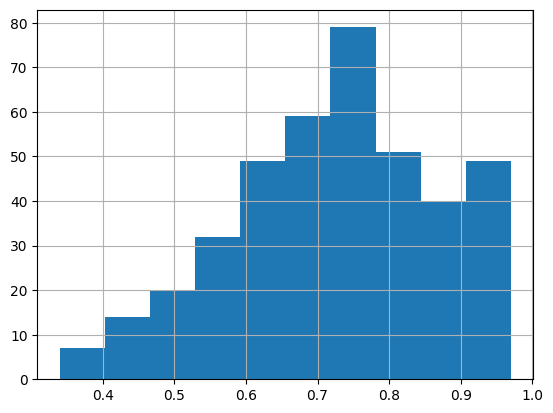

In [100]:
print(f'Кол-во строк {data.shape[0]} и столбцов: {data.shape[1]}')
target_variable = 'Chance of Admit '
print(f'Целевая переменная: {target_variable}')
print(f'Кол-во уникальных значений целевой переменной: {data[target_variable].nunique()}')
data[target_variable].hist()

In [101]:
print('Кол-во пропусов в колонках: ')
data.isnull().sum()

Кол-во пропусов в колонках: 


,0
Serial No.,0
GRE Score,0
TOEFL Score,0
University Rating,0
SOP,0
LOR,0
CGPA,0
Research,0
Chance of Admit,0


In [102]:
print('Общая информация о датасете')
data[target_variable].describe()

Общая информация о датасете


,Chance of Admit
count,400.000000
mean,0.724350
std,0.142609
min,0.340000
25%,0.640000
50%,0.730000
75%,0.830000
max,0.970000


**Предобработка данных**

1. Нормированные численных переменных

In [103]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

y = data[target_variable]
X = data.drop(columns=[target_variable], axis=1)
X = X.drop('Serial No.', axis=1)

X_ans = StandardScaler().fit_transform(X)

In [104]:
X_ans

array([[ 1.76210664,  1.74697064,  0.79882862, ...,  1.16732114,
         1.76481828,  0.90911166],
       [ 0.62765641, -0.06763531,  0.79882862, ...,  1.16732114,
         0.45515126,  0.90911166],
       [-0.07046681, -0.56252785, -0.07660001, ...,  0.05293342,
        -1.00563118,  0.90911166],
       ...,
       [ 1.15124883,  1.41704229,  0.79882862, ...,  1.16732114,
         1.42900622,  0.90911166],
       [-0.41952842, -0.72749202, -0.07660001, ...,  0.61012728,
         0.30403584, -1.09997489],
       [ 1.41304503,  1.58200646,  0.79882862, ...,  0.61012728,
         1.78160888,  0.90911166]])

2. Разделение данных на тренировочную и тестовую выборки

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X_ans, y, test_size=0.2, random_state=42)

**Оформление данных в виде класса Dataset из библиотеки torch**

In [115]:
testLoader = DataLoader(
    TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test.values, dtype=torch.float32)
    ),
    batch_size=32,
    shuffle=True
)

trainLoader = DataLoader(
    TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train.values, dtype=torch.float32)
    ),
    batch_size=32,
    shuffle=False
)

Выводим получившиеся датасеты

In [116]:
for batch, (inputs, targets) in enumerate(trainLoader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {inputs.shape}")
    print(f"y shape: {targets.shape}")
    break

Batch: 1
X shape: torch.Size([32, 7])
y shape: torch.Size([32])


**Обучение на тренировочном множестве**

Устанавливаем устройство, которое будет использоваться для вычислений.

In [127]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используется устройство: {device}")

Используется устройство: cpu
